#### Submission 1: NLP
# News Category Prediction


Oleh: Diah Ayu Setyaningsih

## Kaggle API configuration

Sebelumnya, upload API token dari kaggle (kaggle.json) ke colab terlebih dahulu.

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Download Dataset

In [2]:
!kaggle datasets download saurabh502/mh-newspred

  0% 0.00/2.68M [00:00<?, ?B/s]
100% 2.68M/2.68M [00:00<00:00, 89.9MB/s]


In [3]:
!unzip /content/mh-newspred.zip

Archive:  /content/mh-newspred.zip
  inflating: Data_Test.xlsx          
  inflating: Data_Train.xlsx         
  inflating: Sample_submission.xlsx  


## Import Module

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Import Dataset
Dataset ini berisi 7628 sampel konten utama dari artikel (STORY) beserta kategorinya (SECTION). Terdapat empat kategori yaitu Politik (0), Teknologi (1), Entertainment (2), dan Bisnis (3).

In [5]:
df = pd.read_excel('/content/Data_Train.xlsx')
df.head()

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3


In [6]:
df.shape

(7628, 2)

In [7]:
df.SECTION.value_counts()

1    2772
2    1924
0    1686
3    1246
Name: SECTION, dtype: int64

## Data Preprocesssing

In [8]:
def remove_stopword(text):
    """ Remove stopword in text.
    # Arguments
        text = string.
    # Returns
        Input text without stopword in it.
    """
    stop = stopwords.words('english')
    result = []
    for word in text.split():
        if word not in stop:
            result.append(word)
    return " ".join(result)

def lemmatize_text(text):
    """ Change every word in a text to its base form if it can be found in wordnet.
    # Arguments
        text = string.
    # Returns
        Input text that has been lemmatized.
    """
    lemmatizer = WordNetLemmatizer()
    result = []
    for word in text.split():
        result.append(lemmatizer.lemmatize(word))
    return " ".join(result)

def text_preprocess(list_text):
    """ Data preprocess for each string in a series. The steps are:
        1. Convert text into lowercase form.
        2. Remove newline.
        3. Remove special character.
        4. Remove stopwords.
        5. Lematization.
    # Arguments
        list_text = A series of string.
    # Returns
        A series of string that has been processed.
    """
    # convert to lowercase
    list_text = list_text.str.lower()
    # remove newline
    list_text = list_text.str.replace(r'\n',' ')
    # remove special character
    list_text = list_text.str.replace(r'[^a-zA-z0-9\s]','')
    # remove stopwords
    list_text = list_text.apply(remove_stopword)
    # Lematization
    list_text = list_text.apply(lemmatize_text)
    return list_text.str.strip()

In [9]:
# before preprocess
df.STORY[3]

'If you want to answer any question, click on ‘Answer’. After clicking on Answer you can also check out replies of other users. Proceed to Answer either through writing or voice command.\n\n\nIf you want to ask any question, click on “Ask A Question". Few question prefixes are already inserted to help you with your questions. After submitting your question, the app will send the questions to your neighbours and will let you know how many neighbours\n\n\nhave been asked the question. Click Done. You can click on the bell icon on the homepage of the app to follow answers to your questions.'

In [10]:
df.STORY = text_preprocess(df.STORY)

In [11]:
#after preprocess
df.STORY[3]

'want answer question click answer clicking answer also check reply user proceed answer either writing voice command want ask question click ask question question prefix already inserted help question submitting question app send question neighbour let know many neighbour asked question click done click bell icon homepage app follow answer question'

## Split Dataset

In [12]:
X = df.STORY.values
y = df.SECTION.values

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  stratify=y, random_state=42)

## Tokenization

In [14]:
tokenizer = Tokenizer(num_words=5000, oov_token='UNK')
tokenizer.fit_on_texts(X_train)
 
sekuens_train = tokenizer.texts_to_sequences(X_train)
sekuens_val = tokenizer.texts_to_sequences(X_val)
 
padded_train = pad_sequences(sekuens_train) 
padded_val = pad_sequences(sekuens_val)

## Create Model

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(128, dropout=0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adamax', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          80000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               74240     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 162,756
Trainable params: 162,756
Non-trainable params: 0
_________________________________________________________________


In [17]:
num_epochs = 15
history = model.fit(padded_train, y_train, epochs=num_epochs, 
                    validation_data=(padded_val, y_val), verbose=2)

Epoch 1/15
191/191 - 20s - loss: 1.2918 - accuracy: 0.4131 - val_loss: 1.1416 - val_accuracy: 0.4902
Epoch 2/15
191/191 - 19s - loss: 1.0187 - accuracy: 0.5610 - val_loss: 0.7907 - val_accuracy: 0.6913
Epoch 3/15
191/191 - 19s - loss: 0.7064 - accuracy: 0.7199 - val_loss: 0.5748 - val_accuracy: 0.7674
Epoch 4/15
191/191 - 19s - loss: 0.6131 - accuracy: 0.7675 - val_loss: 0.5320 - val_accuracy: 0.8145
Epoch 5/15
191/191 - 19s - loss: 0.5723 - accuracy: 0.7720 - val_loss: 0.4722 - val_accuracy: 0.8093
Epoch 6/15
191/191 - 19s - loss: 0.4739 - accuracy: 0.8163 - val_loss: 0.4008 - val_accuracy: 0.8545
Epoch 7/15
191/191 - 19s - loss: 0.3948 - accuracy: 0.8622 - val_loss: 0.3276 - val_accuracy: 0.9024
Epoch 8/15
191/191 - 19s - loss: 0.3275 - accuracy: 0.9009 - val_loss: 0.2918 - val_accuracy: 0.9135
Epoch 9/15
191/191 - 19s - loss: 0.2772 - accuracy: 0.9176 - val_loss: 0.2592 - val_accuracy: 0.9246
Epoch 10/15
191/191 - 19s - loss: 0.2547 - accuracy: 0.9207 - val_loss: 0.2324 - val_accura

## Plot Training History

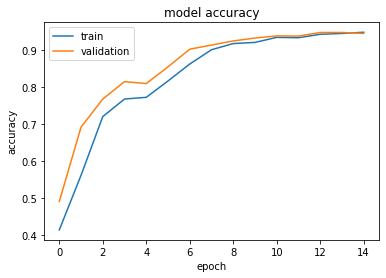

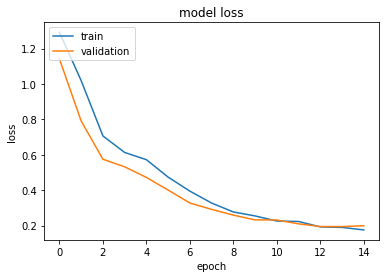

In [18]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Predict on Test Dataset

In [19]:
test_df = pd.read_excel('/content/Data_Test.xlsx')

In [20]:
X_test = text_preprocess(test_df.STORY).values

In [21]:
sekuens_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(sekuens_test) 

In [22]:
y_test = model.predict(padded_test)
test_df['prediction'] = np.argmax(y_test,axis=1)
test_df

,STORY,prediction
0,2019 will see gadgets like gaming smartphones ...,1
1,It has also unleashed a wave of changes in the...,2
2,It can be confusing to pick the right smartpho...,1
3,The mobile application is integrated with a da...,0
4,We have rounded up some of the gadgets that sh...,1
...,...,...
2743,"According to researchers, fraud in the mobile ...",1
2744,The iPhone XS and XS Max share the Apple A12 c...,1
2745,"On the photography front, the Note 5 Pro featu...",1
2746,UDAY mandated that discoms bring the gap betwe...,0


In [23]:
test_df.STORY[0] #prediction: Teknologi

'2019 will see gadgets like gaming smartphones and wearable medical devices lifting the user experience to a whole new level\n\n\nmint-india-wire consumer technologyconsumer technology trends in New Yeartech gadgetsFoldable phonesgaming smartphoneswearable medical devicestechnology\n\n\nNew Delhi: Gadgets have become an integral part of our lives with most of us relying on some form of factor to communicate, commute, work, be informed or entertained. Year 2019 will see some gadgets lifting the user experience to a whole new level. Here’s what we can expect to see:\n\n\nSmartphones with foldable screens: Foldable phones are finally moving from the concept stage to commercial launches. They are made up of organic light-emitting diode (OLED) panels with higher plastic substrates, allowing them to be bent without damage.\n\n\nUS-based display maker Royole Corp’s foldable phone, FlexPai, has already arrived in select markets, while Samsung’s unnamed foldable phone is expected sometime next 

In [24]:
test_df.STORY[1] #prediction: Entertaiment

'It has also unleashed a wave of changes in the MCU that will make sure its future is a lot different than its past\n\n\nKevin Feige had signalled diversity and more representation in the post-phase 3 MCU and Endgame does a lot to showcase the initiative'